## Import Libraries

In [408]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [409]:
df = pd.read_csv("best_clear.csv")

In [410]:
df.shape

(8641, 21)

In [411]:
df.drop('Unnamed: 0', axis=1 ,inplace=True)


In [412]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Goalkeeper,196,30,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
1,Manchester United,Goalkeeper,188,37,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [413]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [414]:
df['age']=df['age'].astype(int)
df['height'] = df['height'].astype(int)

In [415]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
# categorical_features = [ 'team','position']
# numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards','second yellow cards', 'red cards', 'goals conceded','clean sheets', 'minutes played','days_injured','games_injured','award','current_value','highest_value','position_encoded','winger']

In [416]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_features = [col for col in df.columns if df[col].dtype == "object"]

In [417]:
for i in categorical_features:
    print(df[i].value_counts())

team
São Paulo Futebol Clube             37
Santos FC                           37
Grêmio Foot-Ball Porto Alegrense    36
Botafogo de Futebol e Regatas       35
Goiás Esporte Clube                 34
                                    ..
Aston Villa                          5
Tottenham Hotspur                    4
Manchester City                      2
Arsenal FC                           2
Gaziantep FK                         2
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1523
Attack Centre-Forward         1095
Goalkeeper                     953
midfield-CentralMidfield       912
midfield-DefensiveMidfield     746
Defender Right-Back            735
Defender Left-Back             675
midfield-AttackingMidfield     621
Attack-RightWinger             581
Attack-LeftWinger              567
midfield-RightMidfield          88
midfield-LeftMidfield           84
Attack-SecondStriker            48
midfield                         5
Attack                      

In [418]:
df.dtypes

team                    object
position                object
height                   int64
age                      int64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [419]:
categorical_features

['team', 'position']

In [420]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [421]:
df.shape

(8641, 408)

In [422]:
categorical_features

['team', 'position']

In [423]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,196,30,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,...,False,False,False,True,False,False,False,False,False,False
1,188,37,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,...,False,False,False,True,False,False,False,False,False,False


In [424]:
p35 = df['current_value'].quantile(0.25)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['player_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_price_category'].value_counts())

player_price_category
Good_Price     4143
High_Price     2435
Cheap_Price    2063
Name: count, dtype: int64


In [425]:
p35, p75


(350000.0, 2000000.0)

In [426]:
encoder = LabelEncoder()
df['player_price_category'] = encoder.fit_transform(df['player_price_category'])  

#### 3. Feature selection

In [427]:
correlation = df.corr()
print(correlation['player_price_category'].sort_values(ascending=False))

player_price_category    1.000000
highest_value            0.416445
appearance               0.377700
minutes played           0.351331
award                    0.160396
                           ...   
team_Brisbane Roar      -0.058430
team_Richards Bay FC    -0.058430
team_Perth Glory        -0.059026
goals conceded          -0.125621
position_Goalkeeper     -0.162113
Name: player_price_category, Length: 408, dtype: float64


In [428]:
# Set the correlation threshold
threshold = 0.20 # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_price_category']) > threshold]['player_price_category'].index
selected_features

Index(['appearance', 'minutes played', 'highest_value',
       'player_price_category'],
      dtype='object')

In [429]:
selected_features = ['appearance', 'minutes played', 'highest_value',
       'player_price_category']

In [430]:
df = df[selected_features]
df.head()

,appearance,minutes played,highest_value,player_price_category
0,15,1304,22000000,1
1,4,292,6000000,1
2,8,416,20000000,2
3,34,2758,2000000,2
4,39,2788,800000,1


#### 4. Prepare train and test data

In [431]:
# Prepare data
X = df.drop(['player_price_category'], axis=1)
y = df['player_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [432]:
X.shape

(8641, 3)

## Buliding the Model

In [433]:
model = SVC()


In [434]:
param_grid = {
    'kernel': [
            
               'rbf',
             
             
              ],   
    'C':[0, 2, 5, 10, 15, 20, 25],
    'gamma': [1,2,6]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,  
                           scoring='f1_macro', 
                           verbose=1)

In [435]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 21 candidates, totalling 105 fits


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_


{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

## Train the Model

In [ ]:
model = grid_search.best_estimator_


In [ ]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
one_hot_cols = X.select_dtypes(exclude=['float64', 'int64']).columns

scaler = StandardScaler()
X_scaled_numerical = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols)

X_scaled = pd.concat([X_scaled_numerical, X[one_hot_cols].reset_index(drop=True)], axis=1)

In [437]:
from sklearn.metrics import classification_report

# Assuming X_scaled is your preprocessed DataFrame and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the SVC model
svc = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1],
    'gamma': [1, 0.1],
    'kernel': ['linear', 'rbf'],
}

# Set up GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.7s
[CV] END ....................C=0.1, gamma=0.1, ke

## Test the Model

In [439]:
#y_pred = model.predict(X_test)
y_pred = grid_search.predict(X_test)


## Evaluating the Model 

In [441]:
base_model = round(df['player_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

47.95

In [443]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7281665702718334

In [444]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [452]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[246, 140,  33],
       [ 80, 616, 140],
       [  0,  77, 397]])

In [451]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

AttributeError: 'SVC' object has no attribute 'classes_'

In [453]:
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.73


In [454]:
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.72


In [456]:
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.72


array([[<Axes: title={'center': 'appearance'}>,
        <Axes: title={'center': 'minutes played'}>],
       [<Axes: title={'center': 'highest_value'}>,
        <Axes: title={'center': 'player_price_category'}>]], dtype=object)

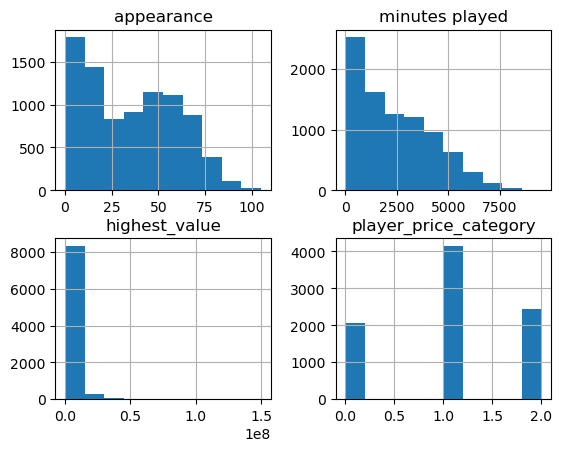

In [450]:
df.hist()


In [458]:
import joblib

joblib.dump(model, '/Users/a7mad/Desktop/git_lab/Usecase-7/SVM_model.joblib')
joblib.dump(scaler, '/Users/a7mad/Desktop/git_lab/Usecase-7/scaler.joblib')

['/Users/a7mad/Desktop/git_lab/Usecase-7/scaler.joblib']

In [459]:
df

,appearance,minutes played,highest_value,player_price_category
0,15,1304,22000000,1
1,4,292,6000000,1
2,8,416,20000000,2
3,34,2758,2000000,2
4,39,2788,800000,1
...,...,...,...,...
8636,45,3256,1200000,1
8637,12,813,1000000,1
8638,35,2160,3000000,1
8639,32,1588,200000,0
